In [25]:
###### Imports ######
import numpy as np
import math
import time
import scipy.fft as fft
import skimage
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit, prange

In [58]:
###### Image generation functions ######

###### Amplitudes ################################################################################

# Reference beam amplitude on each pixel (reference beam is Gaussian)
@jit(nopython = True)
def reference_amplitude(x, y, sigma, ref_amplitude):
    ### ref_amplitude is the sqrt of the number of photons on the on an area dx*dy in the center of the screen:
    return ref_amplitude * np.exp(- 0.25 * (x**2 + y**2)/sigma**2) ### careful: This is sqrt(gauss)!!!

# Signal ampliutde on each pixel
@jit(nopython = True)
def signal_amplitude(x, y, dx, dy, f, lens_diameter, sig_intensity, walk_sigma, signal_norm, wavelength):
    ### solid angle of each pixel is approximated: SQRT(Number of phtons in solid angle is returned)
    if ((0.5*lens_diameter)**2 < x**2 + y**2):
        return 0
    quarter_solid_angle = np.arctan((f**2) * dx * dy / (np.sqrt(f**2 + x**2) * np.sqrt(f**2 + y**2) * 2 *np.sqrt(f**2 + x**2 + y**2)
                           * np.sqrt( 4 * (f**2 + x ** 2 + y**2) + (f**2 * dx**2 / (f**2 + x**2)) + (f**2 * dy**2 / (f**2 + y**2)))))
    return np.sqrt(sig_intensity * quarter_solid_angle / (np.pi * dx * dy) * signal_norm * np.exp(- 0.5 * (x**2 + y**2) * (walk_sigma / (f* wavelength)) **2))


###### Interference ################################################################################

# Only the signal-reference interference is calculated. Signal-signal interference is neglected
@jit(nopython = True)
def ref_signal_interference(x, y, dx, dy, atoms_x, atoms_y, angle, ref_azimuth, ref_amplitude, ref_sigma, focal_length, lens_diameter, sig_intensity, walk_sigma, PSF_norm, wavelength):
    kx_ref = (2 * np.pi / wavelength) * np.sin(angle * np.pi/180) * np.cos(ref_azimuth * np.pi/180)
    ky_ref = (2 * np.pi / wavelength) * np.sin(angle * np.pi/180) * np.sin(ref_azimuth * np.pi/180)
    amplitude_ref = reference_amplitude(x, y, ref_sigma, ref_amplitude)
    intensity = 0
    for i in np.arange(len(atoms_x)):
        amplitude_atom = signal_amplitude(x, y, dx, dy, focal_length, lens_diameter, sig_intensity, walk_sigma, PSF_norm, wavelength)
        kx = (2 * np.pi / wavelength) * atoms_x[i] / np.sqrt(atoms_x[i]**2 + atoms_y[i]**2 + focal_length**2)
        ky = (2 * np.pi / wavelength) * atoms_y[i] / np.sqrt(atoms_x[i]**2 + atoms_y[i]**2 + focal_length**2)
        intensity = intensity + 2 * (amplitude_ref * amplitude_atom * 0.25 * 
                                                            ((np.cos((kx_ref + kx) * (x+dx) + (ky_ref + ky) * (y-dy)) + np.cos((kx_ref + kx) * (x-dx) + (ky_ref + ky) * (y+dy))
                                                             - np.cos((kx_ref + kx) * (x+dx) + (ky_ref + ky) * (y+dy)) - np.cos((kx_ref + kx) * (x-dx) + (ky_ref + ky) * (y-dy))) 
                                                            / ((kx_ref + kx) * (ky_ref + ky))))
    return intensity

####### Higher level functions (Calculate light intensity distribution) ##############################

@jit(nopython=True)
def intensity(x, y, atoms_x, atoms_y, angle, ref_azimuth, ref_amplitude, ref_sigma, dx, dy, focal_length, lens_diameter, sig_intensity, walk_sigma, PSF_norm, wavelength):
    ### Adding up reference and atom intensities (in number of photons) with atom-reference intensiteis
    ### RI is Reference Intensity (in number of photons)
    ### ARI is Signal-Reference interference plus the Signal intensity
    ### Interference of the signals of different atoms among themselves is not taken into account
    RI = reference_amplitude(x, y, ref_sigma, ref_amplitude)**2 *dx * dy
    ARI = ref_signal_interference(x, y, dx, dy, atoms_x, atoms_y, angle, ref_azimuth, ref_amplitude, ref_sigma, focal_length, lens_diameter, sig_intensity, walk_sigma, PSF_norm, wavelength)
    return ARI + RI

@jit(nopython=True, parallel=True)
def generate_image(x_positions, y_positions, atoms_x, atoms_y, angle, ref_azimuth, ref_amplitude, ref_sigma, dx, dy, focal_length, NA, lens_diameter, sig_intensity, walk_sigma, wavelength):
    ### The number of photons at each pixel is calculated with the function "intensity()"
    dimensions = (x_positions.shape[0], y_positions.shape[0])
    PSF_norm = find_PSF_norm(x_positions, y_positions, dx, dy, focal_length, NA, lens_diameter, walk_sigma, wavelength)
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for i in prange(dimensions[0]):
        for j in range(dimensions[1]):
            IMG[i, j] = intensity(x = x_positions[i], y = y_positions[j], atoms_x =  atoms_x, atoms_y = atoms_y, ref_amplitude = ref_amplitude,
                                angle = angle, ref_azimuth = ref_azimuth, ref_sigma = ref_sigma, dx = dx, dy = dy, focal_length = focal_length,
                                lens_diameter = lens_diameter, sig_intensity = sig_intensity, walk_sigma = walk_sigma, PSF_norm = PSF_norm, 
                                wavelength = wavelength)
    return IMG

####### Helper Functions ################################################################################

# Ensure PSFs and solid angle approximation leave signal ampliutde unaltered
@jit(nopython=True)
def find_PSF_norm(x_positions, y_positions, dx, dy, f, NA, lens_diameter, walk_sigma, wavelength):
    norm = 0
    t = 2 / (1 - np.cos(np.arcsin(NA)))
    for x in x_positions:
        for y in y_positions:
            norm = norm + signal_amplitude(x, y, dx, dy, f, lens_diameter, t, walk_sigma, 1, wavelength)**2 * dx*dy
    norm = 1 / norm
    return norm

# Map supersampling pixels to camera pixels
@jit(nopython=True)
def sub_sample(LIGHT, camsize, x_super_sampling, y_super_sampling):
    IMG = np.zeros((camsize[0], camsize[1]))
    IMG_dimensions = np.shape(IMG)
    for i in range(IMG_dimensions[0]):
        for j in range(IMG_dimensions[1]):
            IMG[i, j] = np.sum(LIGHT[x_super_sampling * i:x_super_sampling * (i + 1), y_super_sampling * j:y_super_sampling * (j + 1)])
    return IMG

###### Camera noises ########################################################################################

@jit(nopython=True)
def add_shot_noise(LIGHT, QE):
    dimensions = np.shape(LIGHT)
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            IMG[i, j] = np.random.poisson(LIGHT[i, j] * QE)
    return IMG

def read_noise(camsize, readout_noise):
    return np.random.normal(loc=0.0, scale = readout_noise, size = camsize)

def dark_current_noise(camsize, dark_current, exposure_time):
    return np.random.poisson(dark_current * exposure_time, size = camsize)

###### A signalless image for comparison ######################################################################

@jit(nopython=True, parallel=True)
def generate_background(x_positions, y_positions, dx, dy, ref_amplitude, ref_sigma):
    ### Generates light of just the reference beam alone
    dimensions = (x_positions.shape[0], y_positions.shape[0])
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for i in prange(dimensions[0]):
        for j in range(dimensions[1]):
            IMG[i, j] = reference_amplitude(x_positions[i], y_positions[j], ref_sigma, ref_amplitude) ** 2
    return IMG * dx * dy

Total number of scattered photons per atom:  295.36672493620404


C:\Users\const\AppData\Local\Temp\ipykernel_21696\2414830919.py:113: RuntimeWarning: divide by zero encountered in log
  np.putmask(a, a > 0,np.log(a))
C:\Users\const\AppData\Local\Temp\ipykernel_21696\2414830919.py:113: RuntimeWarning: invalid value encountered in log
  np.putmask(a, a > 0,np.log(a))
C:\Users\const\AppData\Local\Temp\ipykernel_21696\2414830919.py:114: RuntimeWarning: divide by zero encountered in log
  np.putmask(a, a < 0,-np.log(np.absolute(a)))


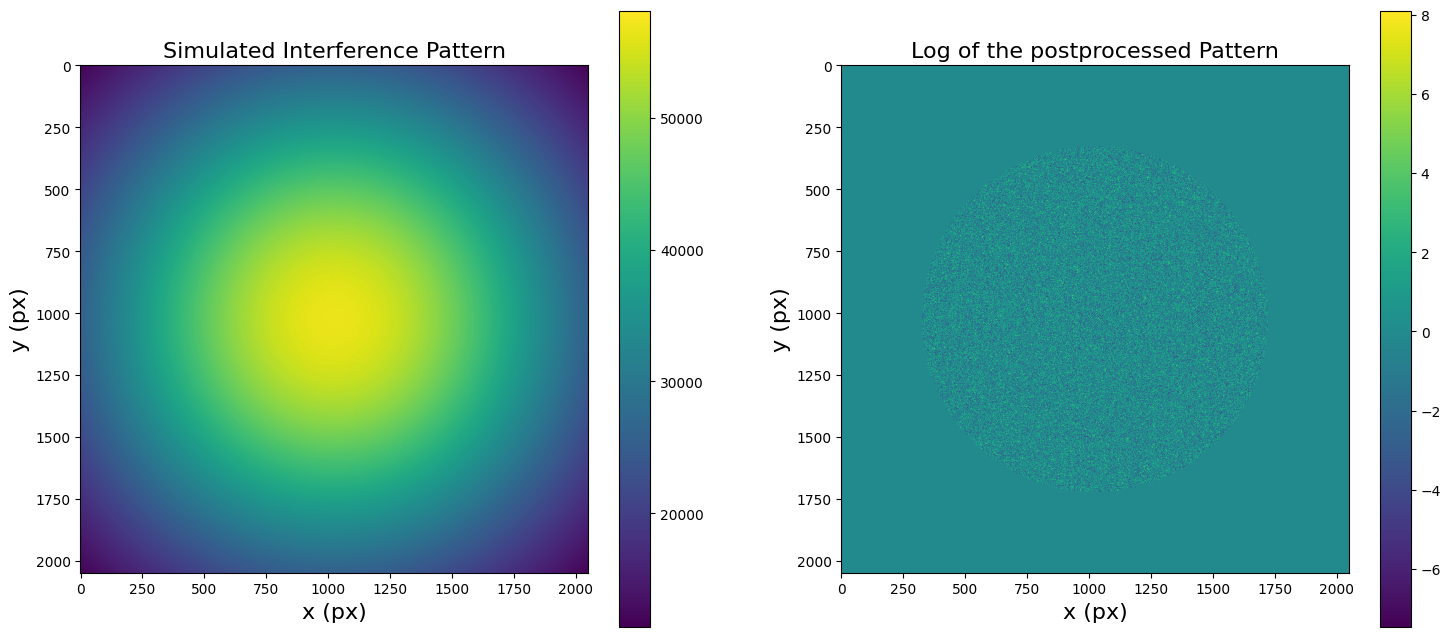

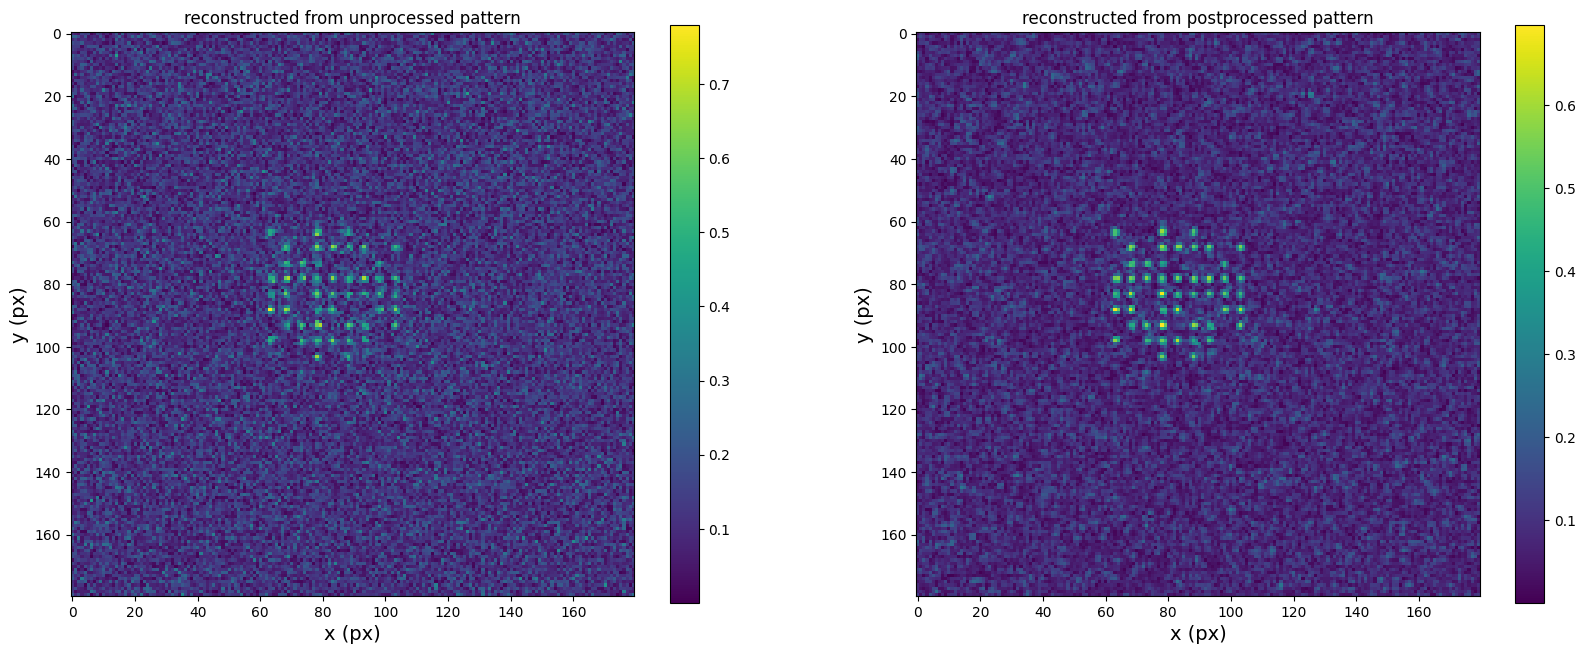

In [62]:

### reference beam settings
wavelength = 671 # nm
ref_intensity = 29e3 # photons / pixel (maximum flux)
angle = 0.84 # degrees (polar angle)
ref_azimuth = 45 # degrees (azimuth)
ref_sigma = 5.3e6 # nm (Gaussian intensity distribution)

### Atom imaging settings
focal_length = 4e6 # nm
NA = 0.75 # numerical aperture
magnification = 1 # ratio
sig_intensity = 80e3 # Coherentely scattered photons per atom. !!! Only used when sig_photons_at_camera < 0 !!!
sig_photons_at_camera = 50 # Photons scettered towards camera sensor. Set to -1 when not in use

### Atom settings
n_atoms = 20 # Number of atoms (only used if random atom ditribution is generated (see below))
walk_sigma = 0.4 # micrometer (random walk standard deviation. Walk is assumed to have a Gaussian distribution)

### Camera parameters
camsize = (2048, 2048) # pixels
pixelsize = 6.5e3 # nm (pixels must be square)
exposure_time = 144e-6 # seconds
QE = 0.9 # Quantum Efficiency
readout_noise = 1.3 # electrons / pixel
dark_current = 0.5 # electrons / pixel / second
sensitivity = 0.46 # electrons / ADU
well_depth = 30e3

### Simulation settings
x_super_sampling = 1 # Not needed
y_super_sampling = 1 # Not needed
include_shot_noise = True
include_read_noise = True
include_dark_noise = True
convert_to_ADU = True
# Atom positions (0 is in the optical axis)
atoms_x = np.array([0, 3, 5, 1, 3, 4, 5, 6, 8, 1, 2, 3, 7, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 7, 8, 1, 2, 3, 5, 6, 8, 0, 2, 3, 4, 5, 6, 3, 5]) # micrometers
atoms_y = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8]) # micrometers
atoms_x = atoms_x - 4.5
atoms_y = atoms_y - 4.5
### Some functions to produce random atom distributions
#atoms_x = (np.random.rand(n_atoms) * 2 - 1) * 20
#atoms_y = (np.random.rand(n_atoms) * 2 - 1) * 20
#atoms_r = np.sqrt(np.random.rand(n_atoms)) * 40
#atoms_phi = np.random.rand(n_atoms) * 2 * np.pi
#atoms_x = np.multiply(atoms_r, np.cos(atoms_phi))
#atoms_y = np.multiply(atoms_r, np.sin(atoms_phi))
#atoms_x = np.array([0, 0, 20, 10, 13])
#atoms_y = np.array([0,10, 20, 15, 7])

###############################################################################################
###### Program ################################################################################
###############################################################################################

### Convert settings to function parameters
x_positions = np.linspace(-camsize[0]/2 + 0.5, camsize[0]/2 - 0.5, camsize[0] * x_super_sampling) * pixelsize
y_positions = np.linspace(-camsize[1]/2 + 0.5, camsize[1]/2 - 0.5, camsize[1] * y_super_sampling) * pixelsize
atoms_x = 1000 * atoms_x * magnification
atoms_y = 1000 * atoms_y * magnification
walk_sigma = 1000 *  walk_sigma * magnification
dx = pixelsize / x_super_sampling
dy = pixelsize / y_super_sampling
ref_amplitude = np.sqrt(ref_intensity) / pixelsize
lens_diameter = 2 * focal_length * np.tan(np.arcsin(NA))
if sig_photons_at_camera >= 0:
    sig_intensity = 2 * sig_photons_at_camera / (1 - np.cos(np.arcsin(NA)))
print("Total number of scattered photons per atom: ", sig_intensity)
### Generate light
LIGHT = generate_image(x_positions = x_positions, y_positions = y_positions, atoms_x = atoms_x, atoms_y = atoms_y, ref_amplitude = ref_amplitude,
                        angle = angle, ref_azimuth = ref_azimuth, ref_sigma = ref_sigma, dx = dx, dy = dy, NA = NA, focal_length = focal_length, lens_diameter = lens_diameter,
                        sig_intensity = sig_intensity, walk_sigma = walk_sigma, wavelength = wavelength)

### Downsample to pixels
IMG = sub_sample(LIGHT, camsize, x_super_sampling, y_super_sampling)

### Add Noise
if include_shot_noise:
    IMG = add_shot_noise(IMG, QE)
if include_dark_noise:
    IMG = IMG + dark_current_noise(camsize, dark_current, exposure_time)
np.putmask(IMG, IMG > well_depth, well_depth) # Saturate at pixel well depth
if include_read_noise:
    IMG = IMG + read_noise(camsize, readout_noise)
if convert_to_ADU:
    IMG = np.round(IMG / sensitivity)
IMG = np.array(IMG).T

####### Some postprocessing (not very relevant to the simulation, but would be done in an experiment) ############################
### Generate a background image. This is not affected by noise. In experiment it would be acquired from averaging over many images.
### In principle this could help reduce fixed pattern noise and non linearity.
### As these are not taken into account in this simulation, this step could in principle be left out.
background = np.array(generate_background(x_positions, y_positions, dx, dy, ref_amplitude, ref_sigma) * QE / sensitivity).T
filtered_IMG = IMG - background
### Set everything outside the lens diameter to 0 as these pixels do not carry any signal, only noise (the effect is not substantial)
for i in range(camsize[0]):
    for j in range(camsize[1]):
        if x_positions[i]**2 + y_positions[j]**2 > (0.5*lens_diameter)**2:
            filtered_IMG[i,j] = 0


####### Show images ###############################################################################################################
# Interference patterns
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(IMG) #cmap = cmap
plt.title("Simulated Interference Pattern", fontsize=16)
plt.xlabel('x (px)', fontsize=16)
plt.ylabel('y (px)', fontsize=16)
plt.colorbar()
plt.subplot(122)
plt.title("Log of the postprocessed Pattern", fontsize=16)
a = np.array(filtered_IMG)
np.putmask(a, a > 0,np.log(a))
np.putmask(a, a < 0,-np.log(np.absolute(a)))
plt.imshow(a) #cmap = cmap
plt.xlabel('x (px)', fontsize=16)
plt.ylabel('y (px)', fontsize=16)
plt.colorbar()

# Reconstructed Images
plt.figure(figsize=(20,7.5))
plt.subplot(121)
plt.title("reconstructed from unprocessed pattern")
plt.imshow(np.absolute(np.fft.ifft2(IMG)[120:300,120:300]))
plt.xlabel('x (px)', fontsize=14)
plt.ylabel('y (px)', fontsize=14)
plt.colorbar()
plt.subplot(122)
plt.title("reconstructed from postprocessed pattern")
plt.imshow(np.absolute(np.fft.ifft2(filtered_IMG)[120:300,120:300]))#, cmap=mpl.colormaps["Greys"])
plt.xlabel('x (px)', fontsize=14)
plt.ylabel('y (px)', fontsize=14)
plt.colorbar()